In [ ]:
import numpy as np
import h5py
import pandas as pd
from scipy.stats import rankdata
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

from meta_feature import dataset_ids_CC18, anchor_list_denser, feature_num_CC18, class_num_CC18, learner_zoo

In [2]:
file_paths = Path.cwd() / '../dataset/LCDB11_ER_CC18_24.hdf5'
dataset = h5py.File(file_paths , 'r')['error rate'][...] 
dataset_nofs, dataset_minmaxfs, dataset_standardfs = dataset[..., 0, 0], dataset[..., 1, 0], dataset[..., 2, 0]

In [3]:
mean_valid_nofs = np.nanmean(dataset_nofs[:,:,:,:,:,1], axis=(2,3))
mean_valid_minmaxfs = np.nanmean(dataset_minmaxfs[:,:,:,:,:,1], axis=(2,3))
mean_valid_standardfs = np.nanmean(dataset_standardfs[:,:,:,:,:,1], axis=(2,3))

min_valid_noFS = np.nanmin(mean_valid_nofs, axis=2)
mean_min_valid_noFS = np.nanmean(min_valid_noFS, axis=0)

min_valid_minmaxFS = np.nanmin(mean_valid_minmaxfs, axis=2)
mean_min_valid_01FS = np.nanmean(min_valid_minmaxFS, axis=0)

min_valid_standardFS = np.nanmin(mean_valid_standardfs, axis=2)
mean_min_valid_standardFS = np.nanmean(min_valid_standardFS, axis=0)

### check difference

In [4]:
dataset_nofs_leak, dataset_minmaxfs_leak, dataset_standardfs_leak = dataset[..., 0, 1], dataset[..., 1, 1], dataset[..., 2, 1]

def calculate_diff_ratio(dataset_noleak, dataset_leak):
    diff_matrix = np.full((dataset_noleak.shape[1], dataset_noleak.shape[0]), np.nan)

    for data_idx in range(dataset_noleak.shape[0]):
        for learner_idx in range(dataset_noleak.shape[1]):
            lc_clean = dataset_leak[data_idx, learner_idx, :, :, :, 1].reshape(-1, 137)
            lc_real = dataset_noleak[data_idx, learner_idx, :, :, :, 1].reshape(-1, 137)

            mask_indices = np.any((~np.isnan(lc_clean)) & (~np.isnan(lc_real)), axis=0)
            num_anchor = np.count_nonzero(mask_indices)
            lc_clean = lc_clean[:, mask_indices]
            lc_real = lc_real[:, mask_indices]

            if num_anchor == 0: 
                diff_matrix[learner_idx, data_idx] = 1
            else:
                corrected_p_value_list = []
                for anchor_idx in range(num_anchor):
                    if (lc_clean[:, anchor_idx] == lc_real[:, anchor_idx]).all():
                        corrected_p_value = 1
                    else: 
                        _, p_value = ttest_ind(lc_clean[:, anchor_idx], lc_real[:, anchor_idx])
                        corrected_p_value = p_value * num_anchor    # Bonferroni correction

                    corrected_p_value_list.append(corrected_p_value)
                
                if any(p < 0.05 for p in corrected_p_value_list):
                    diff_matrix[learner_idx, data_idx] = 0  
                else: 
                    diff_matrix[learner_idx, data_idx] = 1 

    return np.sum(diff_matrix == 0) / diff_matrix.size


ratio_nofs = calculate_diff_ratio(dataset_nofs, dataset_nofs_leak)
print("no FS difference ratio:", ratio_nofs)
ratio_minmax = calculate_diff_ratio(dataset_minmaxfs, dataset_minmaxfs_leak)
print("min-max FS difference ratio:", ratio_minmax)
ratio_standard = calculate_diff_ratio(dataset_standardfs, dataset_standardfs_leak)
print("standard FS difference ratio:", ratio_standard)


no FS difference ratio: 0.016981132075471698
min-max FS difference ratio: 0.1540880503144654
standard FS difference ratio: 0.125


### average best performance

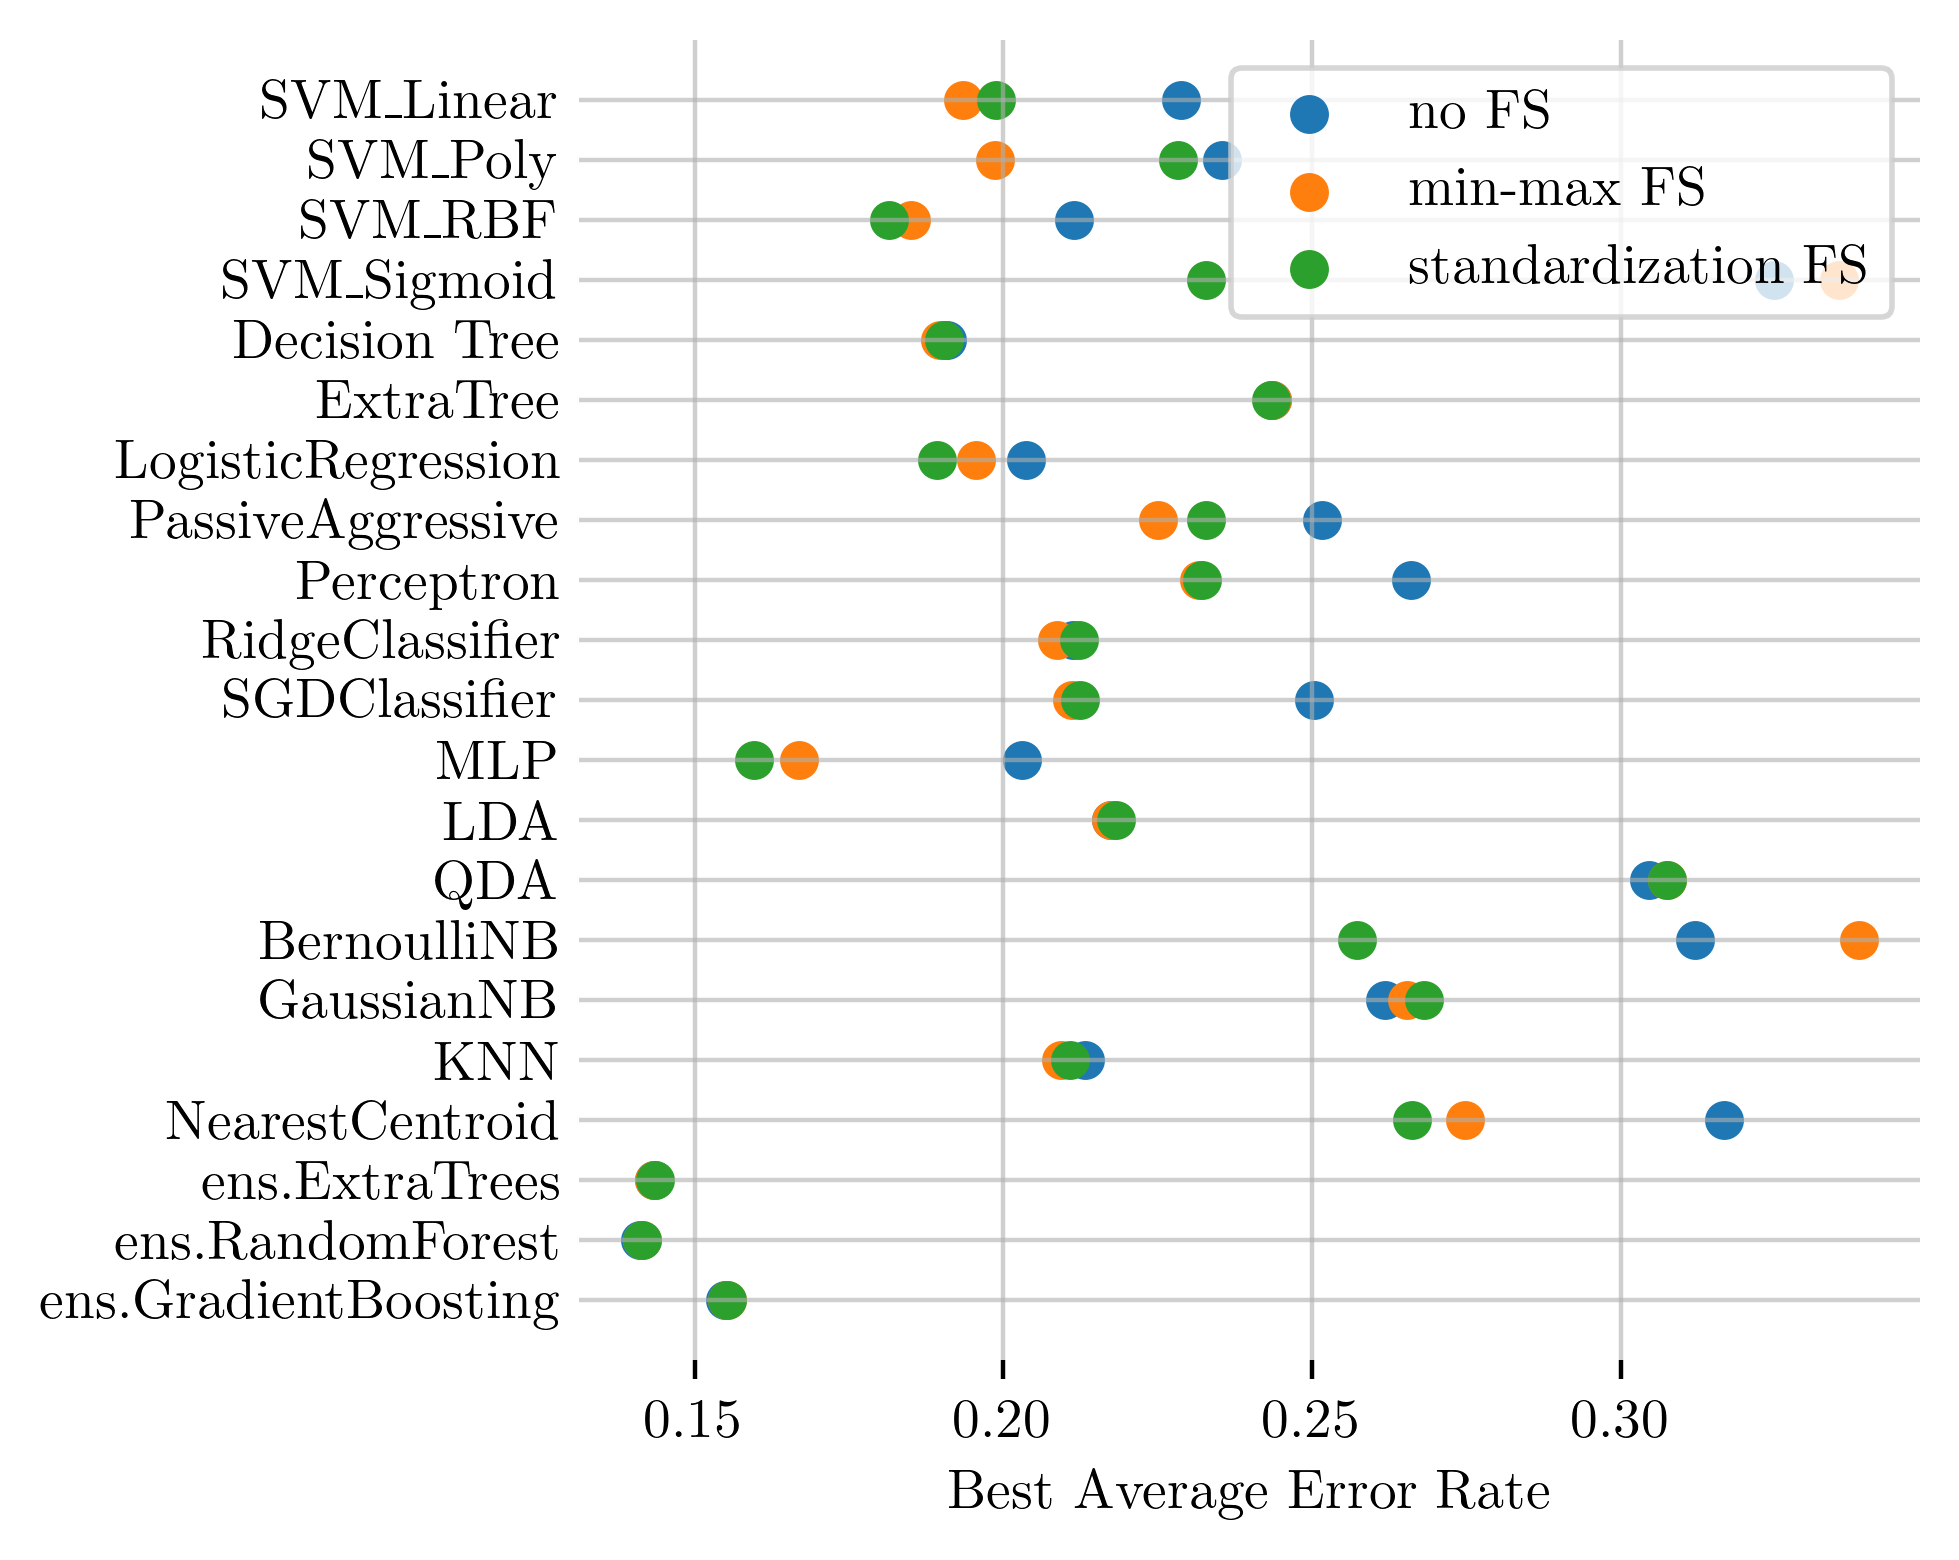

In [6]:
selected_learners = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]

mean_min_valid_noFS_selected = [mean_min_valid_noFS[i] for i in selected_learners]
mean_min_valid_minmaxFS_selected = [mean_min_valid_01FS[i] for i in selected_learners]
mean_min_valid_standardFS_selected = [mean_min_valid_standardFS[i] for i in selected_learners]
learner_zoo_selected = [learner_zoo[i] for i in selected_learners]

x_pos = np.arange(len(selected_learners))[::-1]

plt.figure(figsize=(5, 4), dpi=400)


plt.scatter(mean_min_valid_noFS_selected, x_pos, label='no FS')
plt.scatter(mean_min_valid_minmaxFS_selected, x_pos, label='min-max FS')
plt.scatter(mean_min_valid_standardFS_selected, x_pos, label='standardization FS')
plt.grid(axis='both', alpha=0.6)
plt.tick_params(axis='y', length=0)  
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.yticks(x_pos, learner_zoo_selected)
plt.legend()
plt.xlabel("Best Average Error Rate")
plt.tight_layout()
plt.show()


In [8]:
# selected_learners = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21, 22]
# max_valid_noFS_selected = min_valid_noFS[:, selected_learners]
# max_valid_01FS_selected = min_valid_minmaxFS[:, selected_learners]
# max_valid_standardFS_selected = min_valid_standardFS[:, selected_learners]
# learner_zoo_selected = [learner_zoo[i] for i in selected_learners]

# rank_noFS_selected = np.nanmean(rankdata(max_valid_noFS_selected, axis=1), axis=0)
# rank_01FS_selected = np.nanmean(rankdata(max_valid_01FS_selected, axis=1), axis=0)
# rank_standardFS_selected = np.nanmean(rankdata(max_valid_standardFS_selected, axis=1), axis=0)


# x_pos = np.arange(len(selected_learners))[::-1]

# plt.figure(figsize=(6, 5), dpi=400)
# plt.scatter(rank_noFS_selected, x_pos, label='no FS')
# plt.scatter(rank_01FS_selected, x_pos, label='min-max FS')
# plt.scatter(rank_standardFS_selected, x_pos, label='standardization FS')
# plt.grid(axis='both', alpha=0.6)
# plt.tick_params(axis='y', length=0)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.xticks(np.arange(1, 21, 1)) 
# plt.yticks(x_pos, learner_zoo_selected)
# # plt.xlim(0,19)
# plt.legend()
# plt.xlabel("Average Rank in CC-18")
# plt.tight_layout()
# plt.show()


### plot NB and mixNB

In [13]:
file_paths = Path.cwd() / '../dataset/LCDB11_ER_265_mixNB.hdf5'
dataset = h5py.File(file_paths , 'r')['error rate'][...] 
dataset_nofs_mixNB, dataset_minmaxfs_mixNB, dataset_standardfs_mixNB = dataset[..., 0, 0], dataset[..., 1, 0], dataset[..., 2, 0]

In [14]:
mean_valid_nofs_mixNB = np.nanmean(dataset_nofs_mixNB[:,:,:,:,:,1], axis=(2,3))
mean_valid_minmaxfs_mixNB = np.nanmean(dataset_minmaxfs_mixNB[:,:,:,:,:,1], axis=(2,3))
mean_valid_standardfs_mixNB = np.nanmean(dataset_standardfs_mixNB[:,:,:,:,:,1], axis=(2,3))

min_valid_noFS_mixNB = np.nanmin(mean_valid_nofs_mixNB, axis=2)
# mean_min_valid_noFS_mixNB = np.nanmean(min_valid_noFS_mixNB, axis=0)

min_valid_minmaxFS_mixNB = np.nanmin(mean_valid_minmaxfs_mixNB, axis=2)
# mean_min_valid_01FS_mixNB = np.nanmean(min_valid_minmaxFS_mixNB, axis=0)

min_valid_standardFS_mixNB = np.nanmin(mean_valid_standardfs_mixNB, axis=2)
# mean_min_valid_standardFS_mixNB = np.nanmean(min_valid_standardFS_mixNB, axis=0)

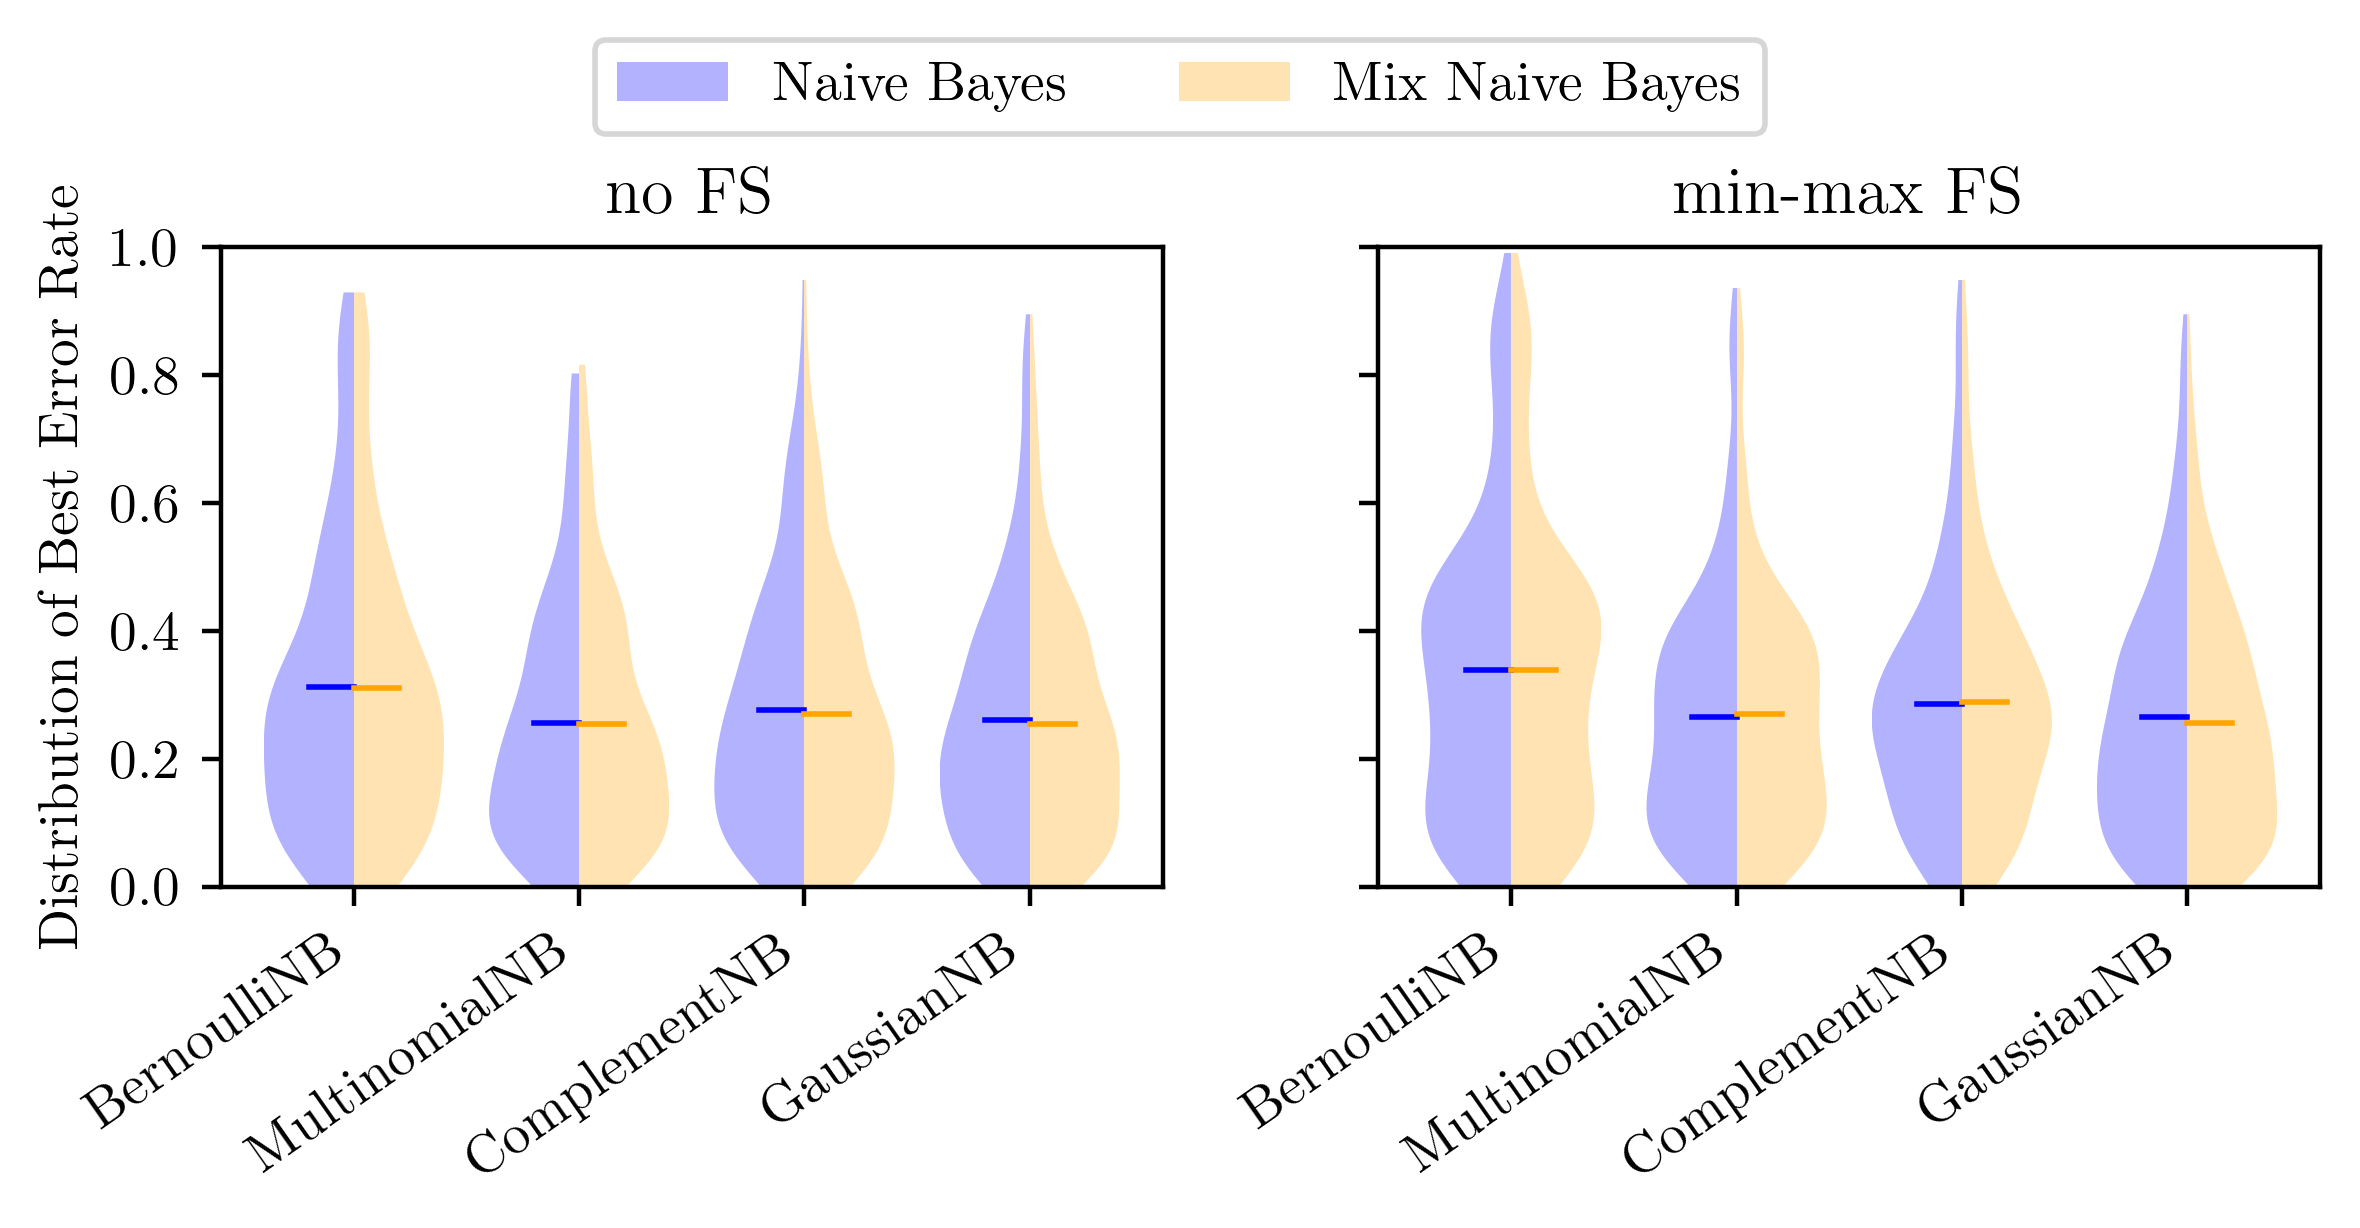

In [15]:
NB_learner = [14, 15, 16, 17]
model_names = [learner_zoo[i] for i in NB_learner]

datasets = {
    'no FS': (min_valid_noFS, min_valid_noFS_mixNB),
    'min-max FS': (min_valid_minmaxFS, min_valid_minmaxFS_mixNB)
}

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=400, sharey=True)

for ax, (title, (min_valid_NB, min_valid_mixNB)) in zip(axes, datasets.items()):
    df_NB = pd.DataFrame(min_valid_NB[:, NB_learner], columns=model_names)
    df_NB['Type'] = 'NB'
    df_mixNB = pd.DataFrame(min_valid_mixNB, columns=model_names)
    df_mixNB['Type'] = 'mixNB'
    df_combined = pd.concat([df_NB, df_mixNB])

    # clean nan
    df_melted = pd.melt(df_combined, id_vars='Type', var_name='Model', value_name='Value')
    df_melted = df_melted.dropna(subset=['Value'])

    positions = np.arange(len(model_names))
    
    for i, model in enumerate(model_names):
        data_NB = df_melted[(df_melted['Model'] == model) & (df_melted['Type'] == 'NB')]['Value'].dropna()
        data_mixNB = df_melted[(df_melted['Model'] == model) & (df_melted['Type'] == 'mixNB')]['Value'].dropna()

        # Violin for NB
        vp_NB = ax.violinplot(data_NB, positions=[i], widths=0.8, showextrema=False)
        for b in vp_NB['bodies']:
            b.set_facecolor('blue')
            b.set_clip_path(plt.Rectangle((i - 0.4, 0), 0.4, 1, transform=ax.transData))

        # Violin for mixNB
        vp_mixNB = ax.violinplot(data_mixNB, positions=[i], widths=0.8, showextrema=False)
        for b in vp_mixNB['bodies']:
            b.set_facecolor('orange')
            b.set_clip_path(plt.Rectangle((i, 0), 0.4, 1, transform=ax.transData))

        # Mean line for NB
        mean_NB = np.mean(data_NB)
        ax.plot([i - 0.2, i], [mean_NB, mean_NB], color='blue', linewidth=1)

        # Mean line for mixNB
        mean_mixNB = np.mean(data_mixNB)
        ax.plot([i, i + 0.2], [mean_mixNB, mean_mixNB], color='orange', linewidth=1)

    ax.set_xticks(positions)
    ax.set_xticklabels(model_names, rotation=35, ha='right')
    ax.set_title(title)
    ax.set_ylim(0, 1)

axes[0].set_ylabel('Distribution of Best Error Rate')  
fig.legend([vp_NB['bodies'][0], vp_mixNB['bodies'][0]], 
           ['Naive Bayes', 'Mix Naive Bayes'], 
           loc='upper center', 
           ncol=2, fontsize=10, 
           bbox_to_anchor=(0.5, 1.03))  

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


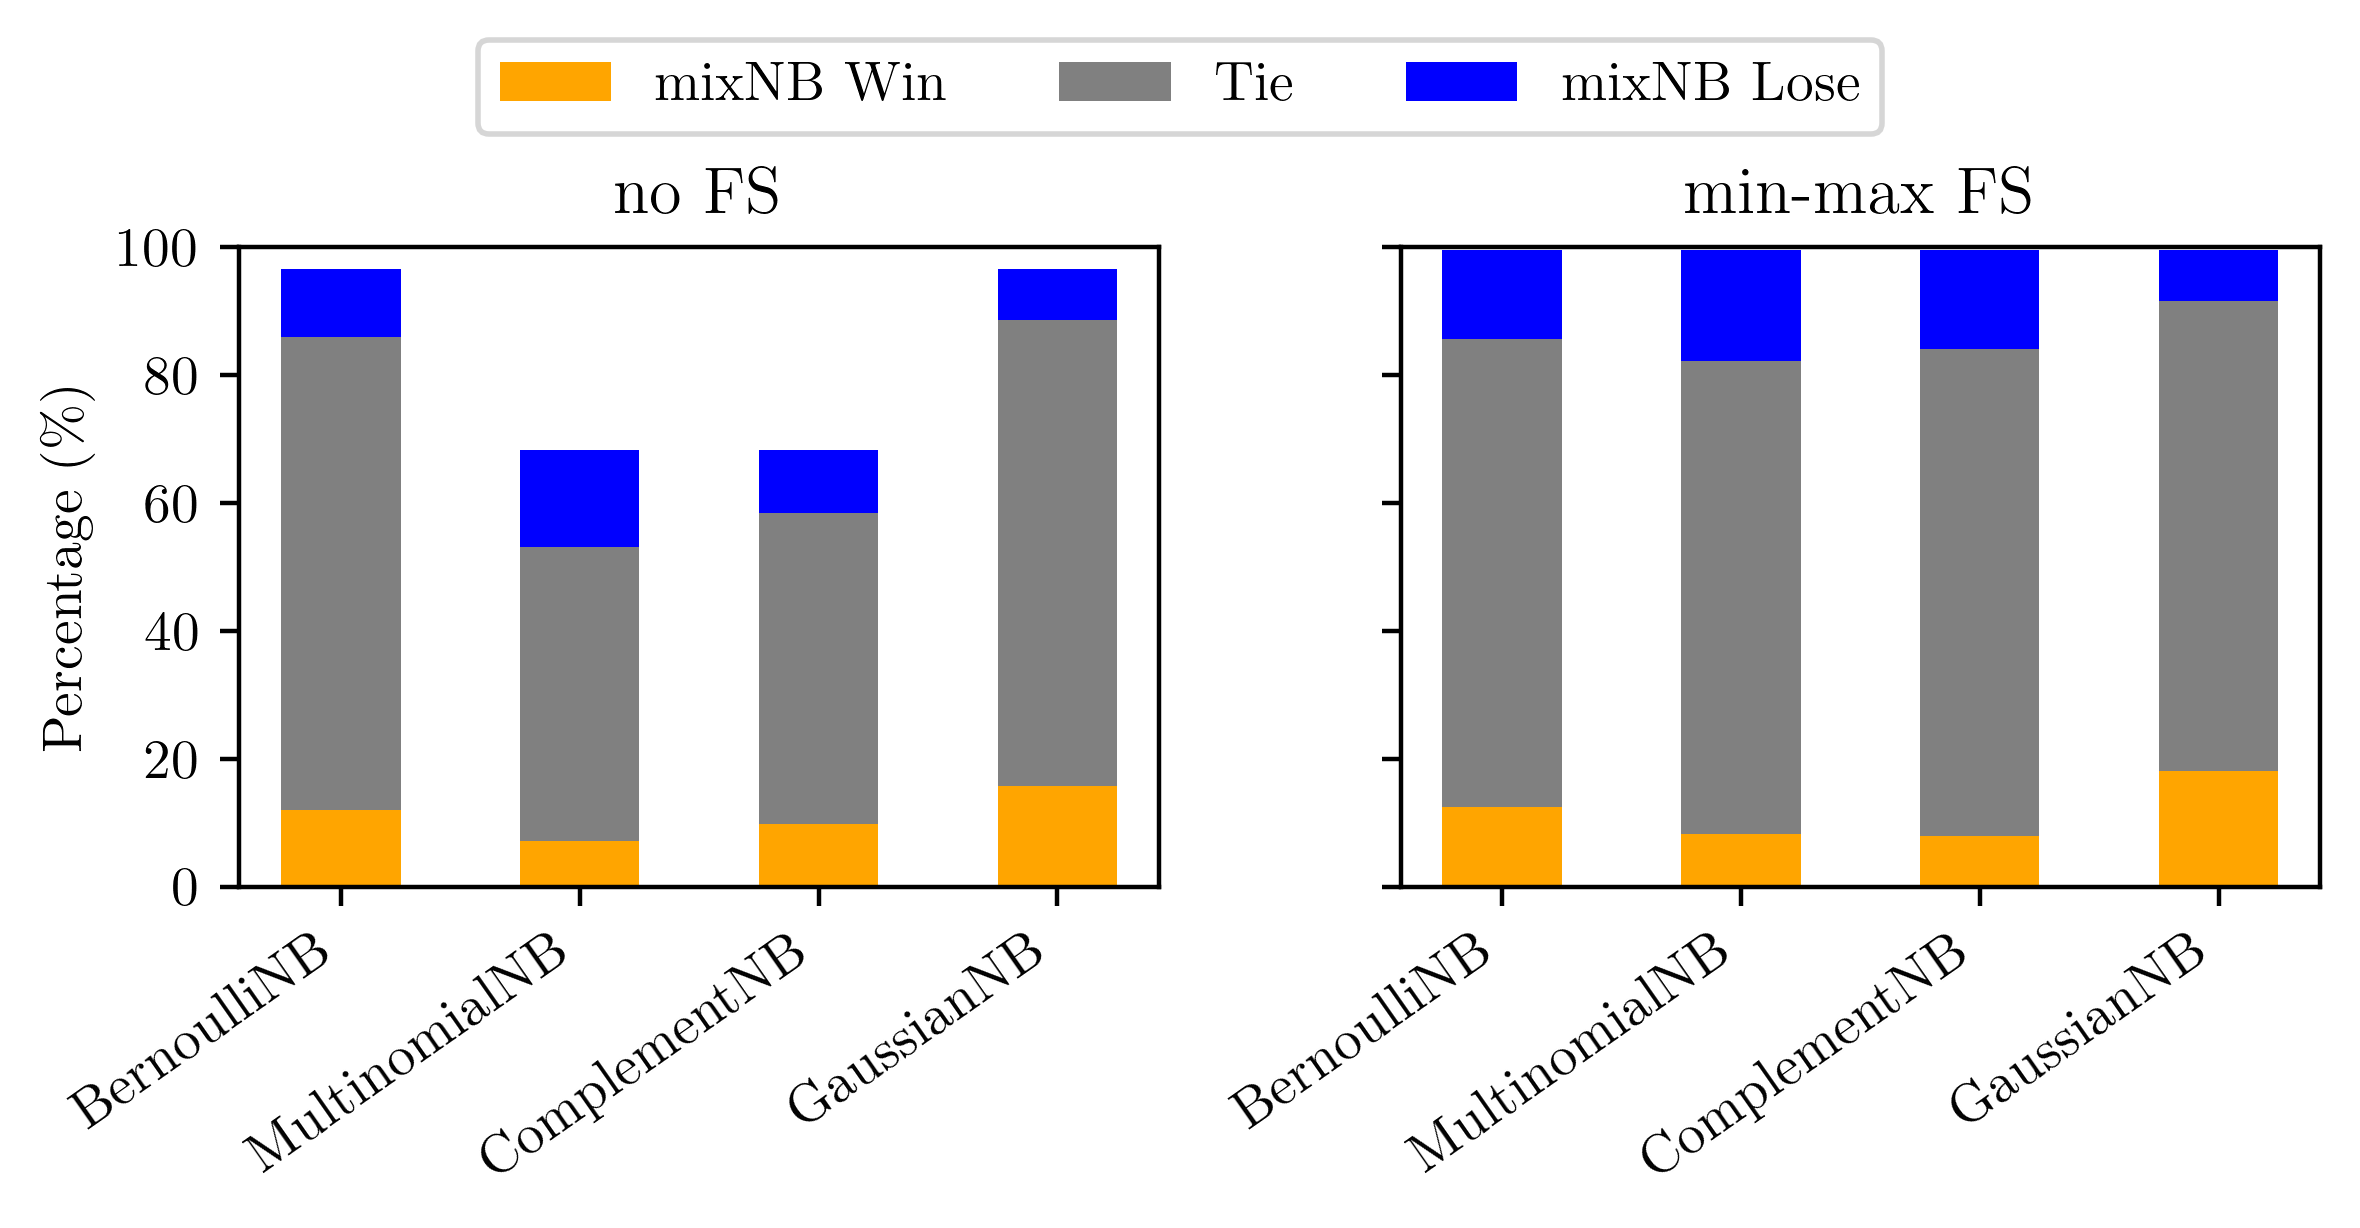

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=400, sharey=True)

for ax_idx, (ax, (title, (min_valid_NB, min_valid_mixNB))) in enumerate(zip(axes, datasets.items())):
    win_percents = []
    lose_percents = []
    tie_percents = []
    total_dataset = min_valid_NB.shape[0]

    for i in NB_learner:
        nb_scores = min_valid_NB[:, i]
        mixnb_scores = min_valid_mixNB[:, model_names.index(learner_zoo[i])]

        # remove NaN
        valid_idx = ~np.isnan(nb_scores) & ~np.isnan(mixnb_scores)
        nb_scores = nb_scores[valid_idx]
        mixnb_scores = mixnb_scores[valid_idx]

        wins = np.sum(mixnb_scores < nb_scores)
        loses = np.sum(mixnb_scores > nb_scores)
        ties = np.sum(mixnb_scores == nb_scores)

        # percentage
        win_percents.append(100 * wins / total_dataset)
        lose_percents.append(100 * loses / total_dataset)
        tie_percents.append(100 * ties / total_dataset)

    bar_width = 0.5
    positions = np.arange(len(model_names))

    bottom_tie = np.array(win_percents)
    bottom_lose = bottom_tie + np.array(tie_percents)

    if ax_idx == 0:
        ax.bar(positions, win_percents, bar_width, label='mixNB Win', color='orange')
        ax.bar(positions, tie_percents, bar_width, bottom=bottom_tie, label='Tie', color='gray')
        ax.bar(positions, lose_percents, bar_width, bottom=bottom_lose, label='mixNB Lose', color='blue')
    else:
        ax.bar(positions, win_percents, bar_width, color='orange')
        ax.bar(positions, tie_percents, bar_width, bottom=bottom_tie, color='gray')
        ax.bar(positions, lose_percents, bar_width, bottom=bottom_lose, color='blue')

    ax.set_xticks(positions)
    ax.set_xticklabels(model_names, rotation=35, ha='right')
    ax.set_title(title)
    ax.set_ylim(0, 100)
    ax.set_yticks(np.arange(0, 110, 20))
    ax.set_yticklabels([f"{y}%" for y in np.arange(0, 110, 20)])

axes[0].set_ylabel(r'Percentage (\%)')

fig.legend(loc='upper center', ncol=3, fontsize=10, bbox_to_anchor=(0.5, 1.03))
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
lc_clean_NB = dataset_nofs[:, 14:18, :, :, :, 1]
lc_clean_mixNB = dataset_nofs_mixNB[:, :, :, :, :, 1]

LEARNER = 0

fig, axes = plt.subplots(9, 8, figsize=(16, 18), dpi=400)

for data_id in range(72):
    row = data_id // 8
    col = data_id % 8
    ax = axes[row, col]
    # means and standard errors
    mean_clean_NB = np.nanmean(lc_clean_NB[data_id, LEARNER, :, :, :], axis=(0, 1))
    se_clean_NB = np.nanstd(lc_clean_NB[data_id, LEARNER, :, :, :], axis=(0, 1), ddof=1) / np.sqrt(np.sum(~np.isnan(lc_clean_NB[data_id, LEARNER, :, :, :]), axis=(0, 1)))
    mean_clean_mixNB = np.nanmean(lc_clean_mixNB[data_id, LEARNER, :, :, :], axis=(0, 1))
    se_clean_mixNB = np.nanstd(lc_clean_mixNB[data_id, LEARNER, :, :, :], axis=(0, 1), ddof=1) / np.sqrt(np.sum(~np.isnan(lc_clean_mixNB[data_id, LEARNER, :, :, :]), axis=(0, 1)))

    ax.plot(anchor_list_denser, mean_clean_NB, label="NB")
    ax.fill_between(anchor_list_denser, mean_clean_NB - se_clean_NB, mean_clean_NB + se_clean_NB, alpha=0.2)

    ax.plot(anchor_list_denser, mean_clean_mixNB, label="MixNB")
    ax.fill_between(anchor_list_denser, mean_clean_mixNB - se_clean_mixNB, mean_clean_mixNB + se_clean_mixNB, alpha=0.2)

    ax.set_title(f'OpenML ID {dataset_ids_CC18[data_id]}', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.legend(fontsize=6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### SVM

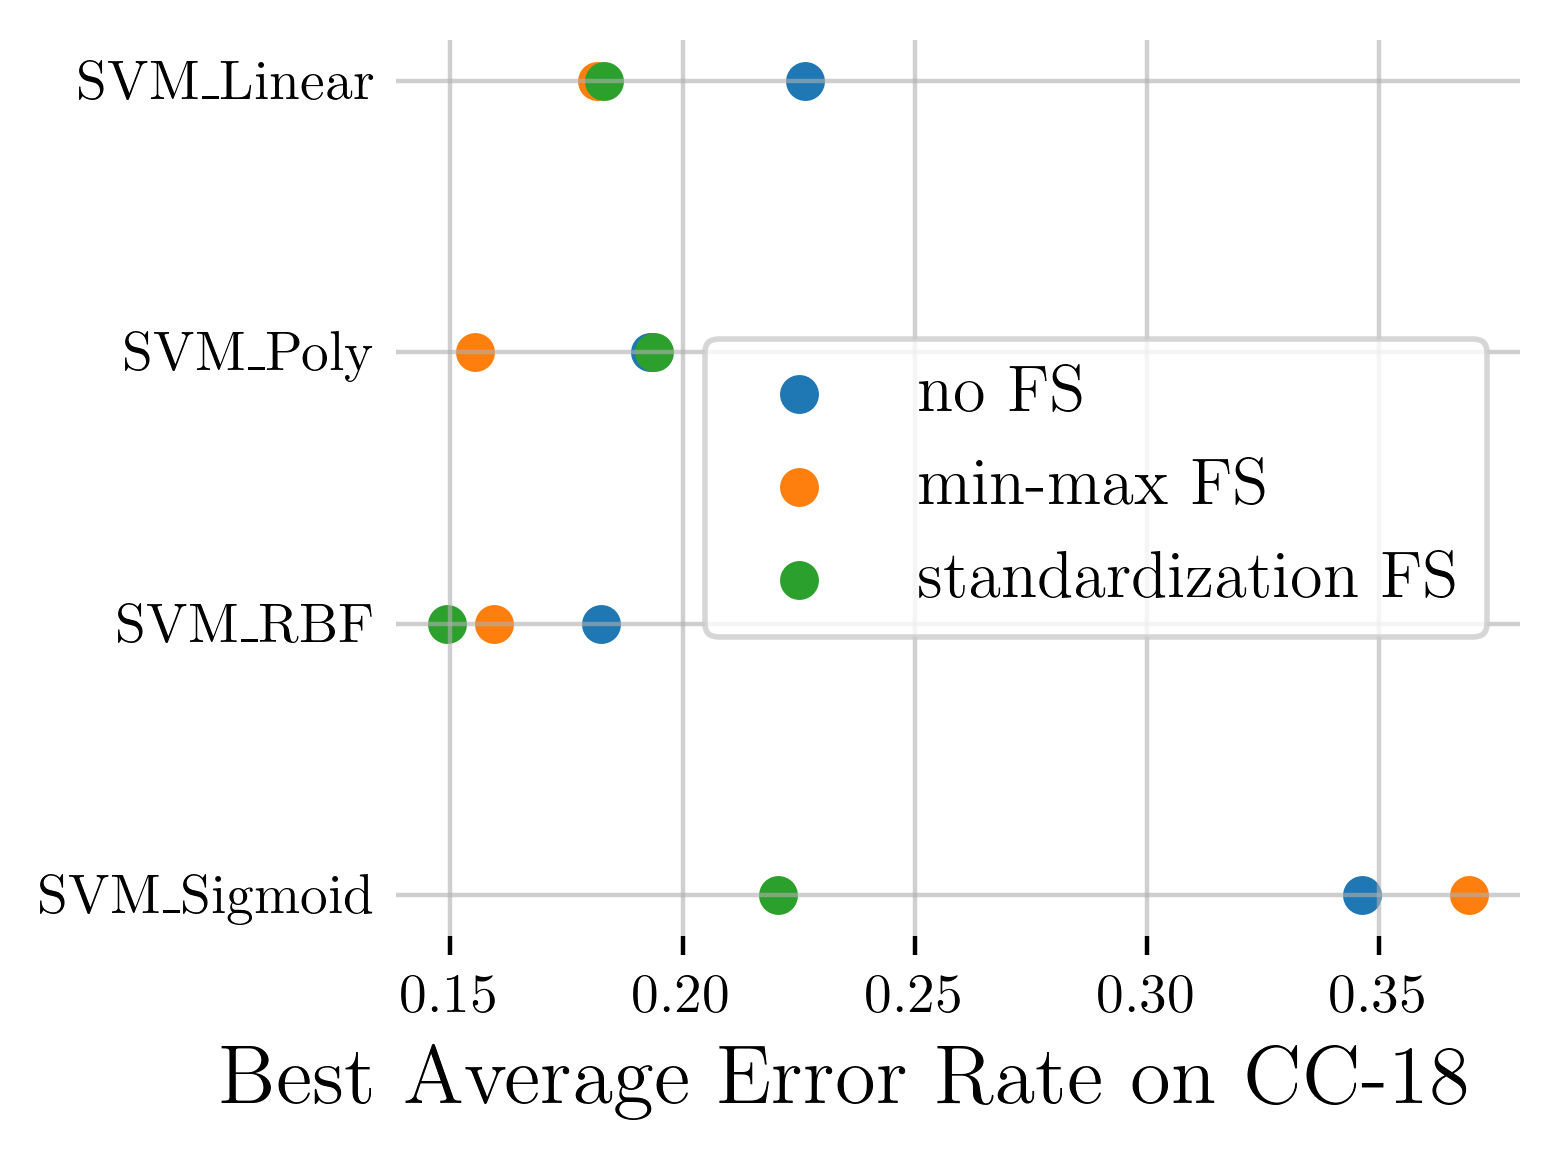

In [15]:
selected_learners = [0, 1, 2, 3]

mean_min_valid_noFS_selected = [mean_min_valid_noFS[i] for i in selected_learners]
mean_min_valid_minmaxFS_selected = [mean_min_valid_01FS[i] for i in selected_learners]
mean_min_valid_standardFS_selected = [mean_min_valid_standardFS[i] for i in selected_learners]
learner_zoo_selected = [learner_zoo[i] for i in selected_learners]

x_pos = np.arange(len(selected_learners))[::-1]

plt.figure(figsize=(4, 3), dpi=400)


plt.scatter(mean_min_valid_noFS_selected, x_pos, label='no FS')
plt.scatter(mean_min_valid_minmaxFS_selected, x_pos, label='min-max FS')
plt.scatter(mean_min_valid_standardFS_selected, x_pos, label='standardization FS')
plt.grid(axis='both', alpha=0.6)
plt.tick_params(axis='y', length=0)  
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.yticks(x_pos, learner_zoo_selected)
plt.legend(loc='center right', fontsize = 12)
plt.xlabel("Best Average Error Rate on CC-18", x=0.4, fontsize = 15)
# plt.title("Average Minimum Error Rate over CC18 (Selected Learners)")
plt.tight_layout()
plt.show()


In [16]:
LEARNER = 0

all_std_nofs = []
all_std_minmaxfs = []
all_std_standardfs = []
for DATASET in range(72):
    all_std_nofs.append(np.nanstd(dataset_nofs[DATASET, LEARNER, :, :, :, 1], axis=(0, 1)))
    all_std_minmaxfs.append(np.nanstd(dataset_minmaxfs[DATASET, LEARNER, :, :, :, 1], axis=(0, 1)))
    all_std_standardfs.append(np.nanstd(dataset_standardfs[DATASET, LEARNER, :, :, :, 1], axis=(0, 1)))

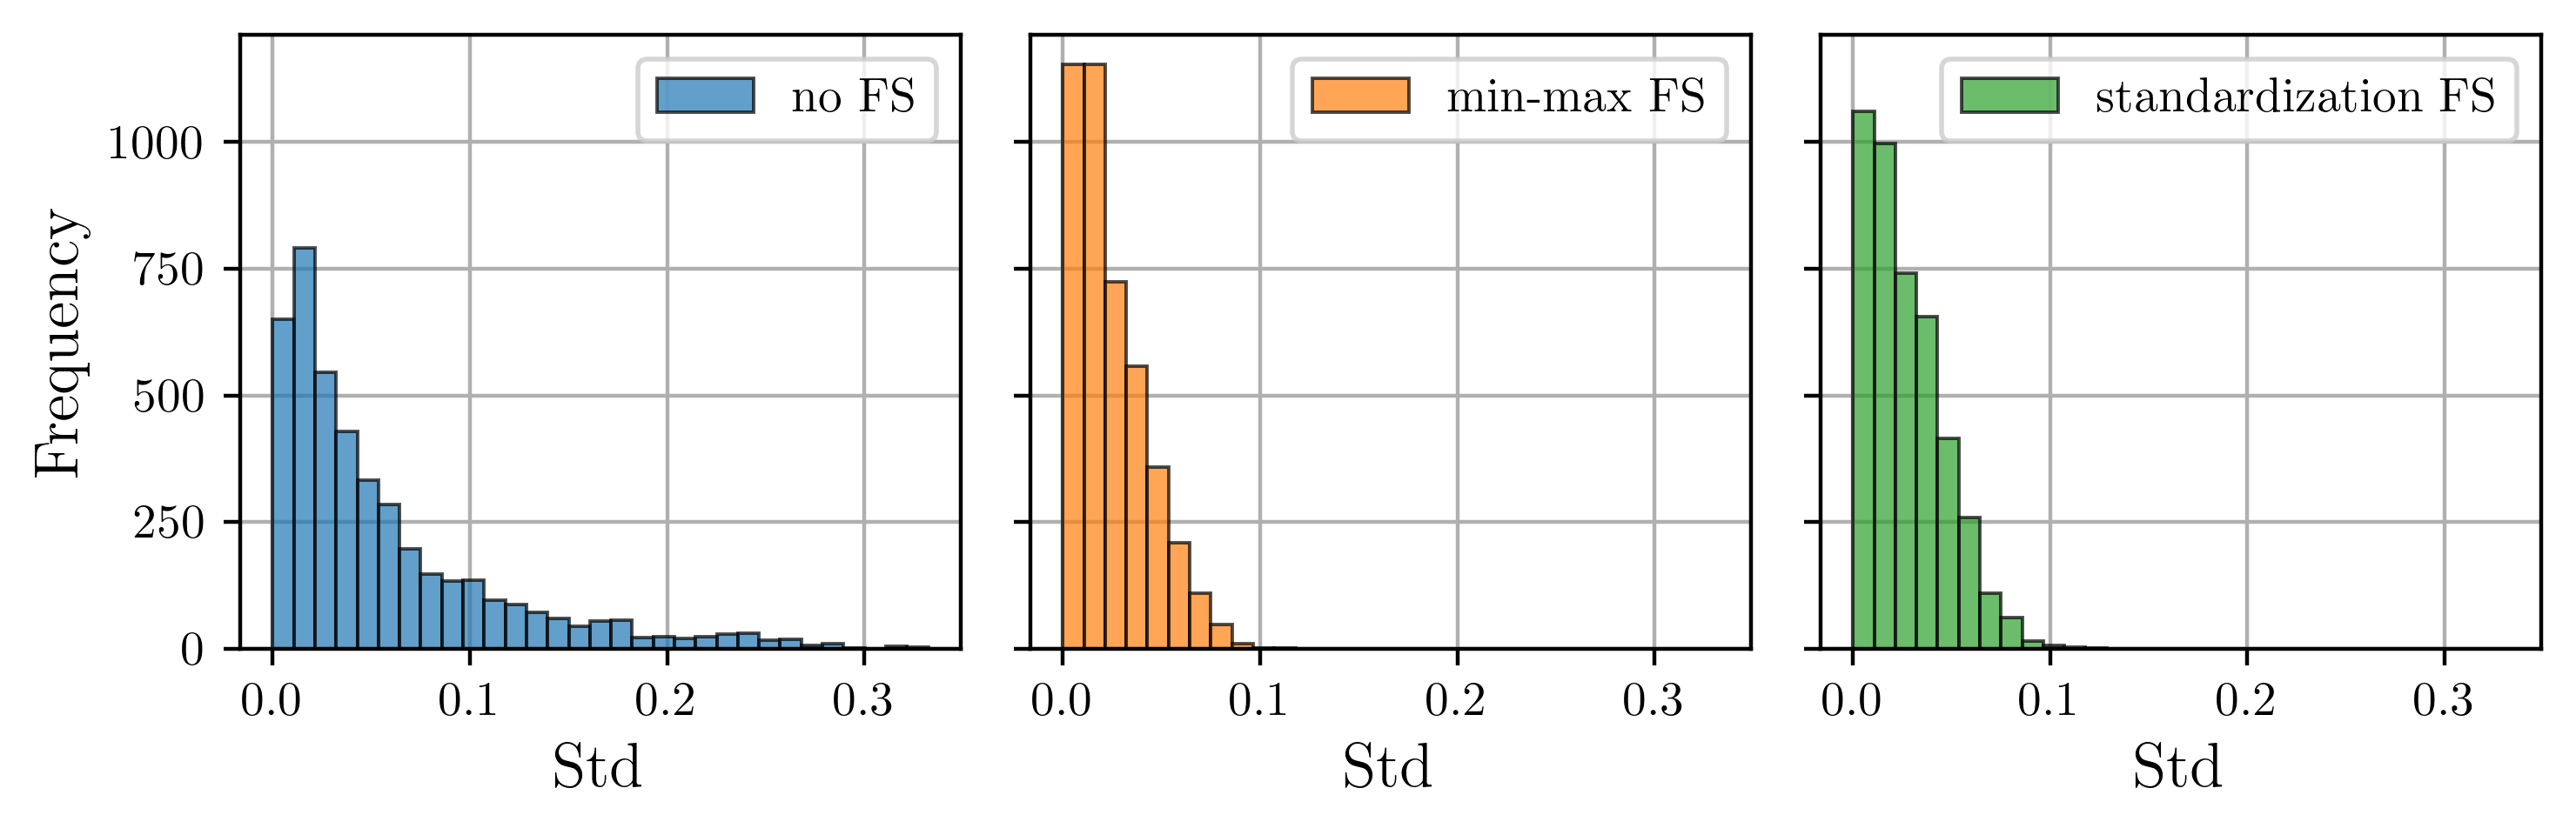

In [22]:
flat_all_std_nofs = np.hstack(all_std_nofs)
flat_all_std_minmaxfs = np.hstack(all_std_minmaxfs)
flat_all_std_standardfs = np.hstack(all_std_standardfs)

# compute a suitable bins
all_data = np.concatenate([flat_all_std_nofs, flat_all_std_minmaxfs, flat_all_std_standardfs])
min_value = np.nanmin(all_data)
max_value = np.nanmax(all_data)

bin_width = (max_value - min_value) / 30
bins = np.arange(min_value, max_value + bin_width, bin_width)

fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5), sharey=True, sharex=True, dpi=400)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

axes[0].hist(flat_all_std_nofs, bins, color=default_colors[0], edgecolor='black', linewidth=0.7, alpha=0.7, label = 'no FS')
axes[0].set_xlabel("Std", fontsize = 13)
axes[0].set_ylabel("Frequency", fontsize = 13)
axes[0].legend()
axes[0].set_axisbelow(True)
axes[0].grid(True)

axes[1].hist(flat_all_std_minmaxfs, bins, color=default_colors[1], edgecolor='black', linewidth=0.7, alpha=0.7, label = 'min-max FS')
axes[1].set_xlabel("Std", fontsize = 13)
axes[1].legend()
axes[1].set_axisbelow(True)
axes[1].grid(True)

axes[2].hist(flat_all_std_standardfs, bins, color=default_colors[2], edgecolor='black', linewidth=0.7, alpha=0.7, label = 'standardization FS')
axes[2].set_xlabel("Std", fontsize = 13)
axes[2].legend()
axes[2].set_axisbelow(True)
axes[2].grid(True)

plt.tight_layout()
plt.show()